# ETCI2021 Dataset Cleaning

This notebook cleans the ETCI2021 flood detection dataset by removing patches with excessive nodata (white/black pixels in SAR imagery).

**Dataset**: [ETCI 2021 Competition on Flood Detection](https://nasa-impact.github.io/etci2021/)  
**Problem**: SAR images (VH/VV polarizations) contain patches with nodata artifacts that can degrade model training.

## Contents
1. **Algorithm Explanation** - Step-by-step demonstration on downscaled images
2. **Full Dataset Cleaning** - Performance-optimized execution using Numba + parallel I/O

In [43]:
import cv2
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from numba import jit
from concurrent.futures import ThreadPoolExecutor

## 1. Algorithm Explanation

### 1.1 Dataset Structure

The ETCI2021 dataset is organized as follows:
```
etci2021/
├── train/
│   └── <location_timestamp>/
│       └── tiles/
│           ├── vh/          # VH polarization SAR patches
│           ├── vv/          # VV polarization SAR patches
│           ├── flood_label/ # Flood segmentation masks
│           └── water_body_label/
└── test/
    └── ...
```

Each patch is a 256×256 PNG image. Patches with coordinates `(x, y)` are named like `location_x-N_y-M_vv.png`.

### 1.2 Loading Downscaled Patches for Visualization

To visualize the entire scene, we load all patches and resize them to 16×16 pixels each, creating a mosaic overview.

In [46]:
def load_low_res(zone_path, patch_size=16):
    """
    Load all patches from a zone and create a downscaled mosaic.
    
    Args:
        zone_path: Path to the tiles directory
        patch_size: Size to resize each patch to (default 16x16)
    
    Returns:
        Tuple of (flood_label, vh, vv, water_body_label) numpy arrays
    """
    folders = ["flood_label", "vh", "vv", "water_body_label"]
    
    # Find grid dimensions from filenames
    max_x, max_y = 0, 0
    for file in os.listdir(os.path.join(zone_path, folders[0])):
        if file.endswith(".png"):
            parts = file.replace(".png", "").split("_")
            x = int(parts[-2].split("-")[1])
            y = int(parts[-1].split("-")[1])
            max_x, max_y = max(max_x, x), max(max_y, y)
    
    # Create mosaic arrays
    h, w = (max_x + 1) * patch_size, (max_y + 1) * patch_size
    patches = [np.zeros((h, w, 3), dtype=np.uint8) for _ in folders]
    
    for i, folder in enumerate(folders):
        folder_path = os.path.join(zone_path, folder)
        for file in os.listdir(folder_path):
            if not file.endswith(".png"):
                continue
            parts = file.replace(".png", "").split("_")
            if folder in ["vv", "vh"]:
                x = int(parts[-3].split("-")[1])
                y = int(parts[-2].split("-")[1])
            else:
                x = int(parts[-2].split("-")[1])
                y = int(parts[-1].split("-")[1])
            
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_UNCHANGED)
            if img is not None:
                img = cv2.resize(img, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
                patches[i][x*patch_size:(x+1)*patch_size, y*patch_size:(y+1)*patch_size] = img
    
    return patches

In [47]:
# Load sample zone
SAMPLE_ZONE = "../data/etci2021/train/nebraska_20170309t002110/tiles"
flood_label, vh, vv, water_body_label = load_low_res(SAMPLE_ZONE)

# Convert to single channel (images are grayscale stored as RGB)
vv = vv[:, :, 0]
vh = vh[:, :, 0]
flood_label = flood_label[:, :, 0]
water_body_label = water_body_label[:, :, 0]

print(f"Mosaic shape: {vv.shape}")

Mosaic shape: (384, 672)


### 1.3 Visualizing SAR Data and Labels

SAR images show backscatter intensity. Areas with no data appear as pure white (255) or black (0) patches.

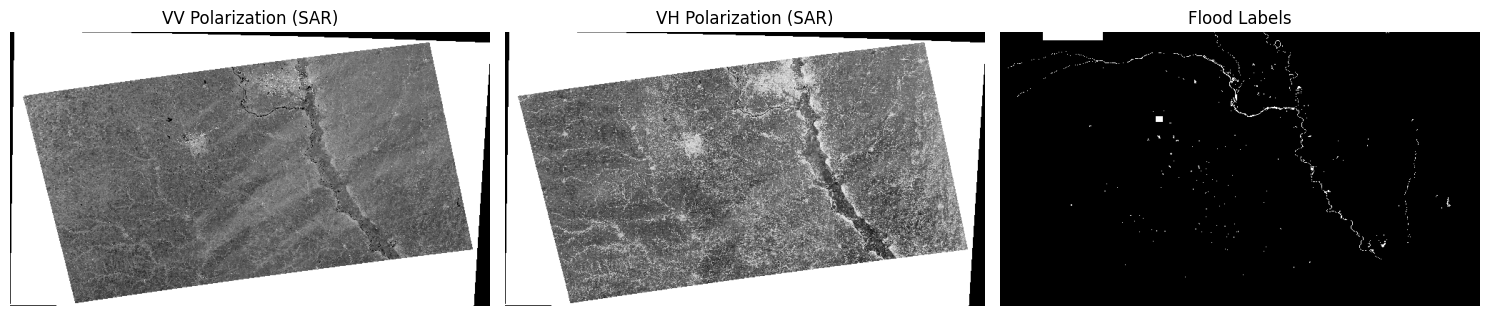

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# VV polarization
axes[0].imshow(vv, cmap='gray')
axes[0].set_title("VV Polarization (SAR)")
axes[0].axis('off')

# VH polarization  
axes[1].imshow(vh, cmap='gray')
axes[1].set_title("VH Polarization (SAR)")
axes[1].axis('off')

# Flood labels
axes[2].imshow(flood_label, cmap='gray')
axes[2].set_title("Flood Labels")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 1.4 Nodata Detection Algorithm

A patch is considered **nodata** if more than 10% of its pixels are pure white (255) or pure black (0). These artifacts typically occur at scene boundaries or due to processing errors.

In [50]:
def detect_nodata_patches(img, patch_size=16, threshold=0.1):
    """
    Detect patches with excessive nodata pixels.
    
    Args:
        img: 2D numpy array (grayscale mosaic)
        patch_size: Size of each patch in the mosaic
        threshold: Fraction of white/black pixels to consider nodata
    
    Returns:
        Boolean mask where True = nodata patch
    """
    nodata_mask = np.zeros(img.shape[:2], dtype=bool)
    
    for i in range(img.shape[0] // patch_size):
        for j in range(img.shape[1] // patch_size):
            patch = img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            nodata_pixels = np.sum(patch == 255) + np.sum(patch == 0)
            total_pixels = patch.shape[0] * patch.shape[1]
            
            if nodata_pixels / total_pixels > threshold:
                nodata_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = True
    
    return nodata_mask

# Detect nodata on VV channel
nodata_mask = detect_nodata_patches(vv)

# Count statistics
total_patches = (vv.shape[0] // 16) * (vv.shape[1] // 16)
nodata_patches = np.sum(nodata_mask) // (16 * 16)
print(f"Total patches: {total_patches}")
print(f"Nodata patches: {nodata_patches} ({nodata_patches/total_patches*100:.1f}%)")

Total patches: 1008
Nodata patches: 396 (39.3%)


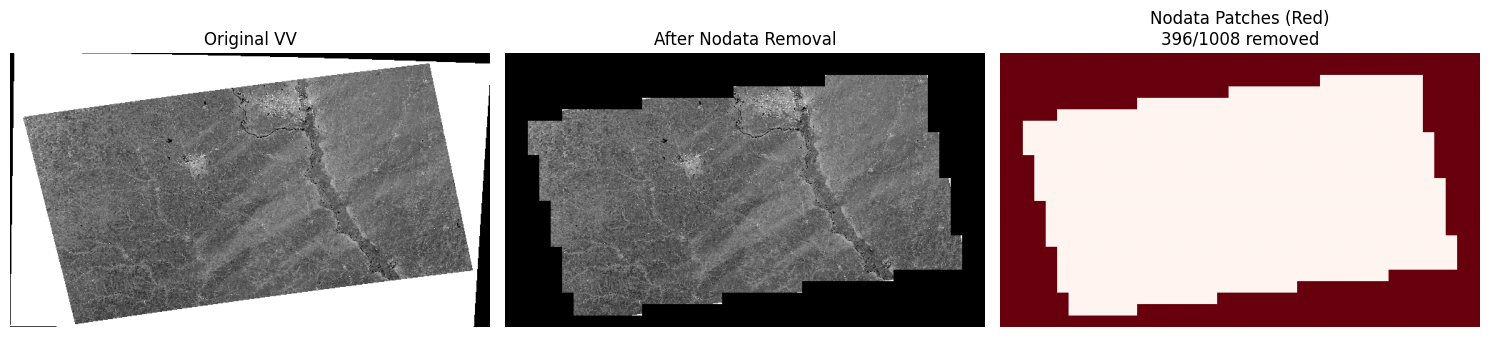

In [51]:
# Visualize nodata detection results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(vv, cmap='gray')
axes[0].set_title("Original VV")
axes[0].axis('off')

# Apply mask to show cleaned version
vv_cleaned = np.where(nodata_mask, 0, vv)
axes[1].imshow(vv_cleaned, cmap='gray')
axes[1].set_title("After Nodata Removal")
axes[1].axis('off')

axes[2].imshow(nodata_mask, cmap='Reds')
axes[2].set_title(f"Nodata Patches (Red)\n{nodata_patches}/{total_patches} removed")
axes[2].axis('off')

plt.tight_layout()
plt.show()

---

## 2. Full Dataset Cleaning

Performance-optimized implementation using:
- **Numba JIT compilation** for fast pixel counting
- **ThreadPoolExecutor** for parallel I/O (reading images, copying files)

In [52]:
from numba import jit
from concurrent.futures import ThreadPoolExecutor
import time

@jit(nopython=True, cache=True)
def is_nodata_patch(img, threshold=0.1):
    """
    Check if a 2D image patch has too many nodata pixels.
    Numba-optimized for fast execution.
    
    Args:
        img: 2D numpy array (single channel)
        threshold: Fraction of nodata pixels to trigger removal
    
    Returns:
        True if patch should be removed
    """
    total_pixels = img.shape[0] * img.shape[1]
    nodata_count = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] == 0 or img[i, j] == 255:
                nodata_count += 1
    return (nodata_count / total_pixels) > threshold


def identify_nodata_fast(patch_path):
    """Load image and check for nodata using Numba-optimized function."""
    try:
        img = cv2.imread(str(patch_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return True
        if img.ndim == 3:
            img = img[:, :, 0]
        return is_nodata_patch(img)
    except:
        return True


def batch_check_nodata(file_paths, max_workers=8):
    """Process multiple files in parallel, return {path: is_nodata}."""
    results = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for path, is_nodata in zip(file_paths, executor.map(identify_nodata_fast, file_paths)):
            results[path] = is_nodata
    return results


# Warm up Numba JIT (compile once)
print("Compiling Numba functions...")
_ = is_nodata_patch(np.zeros((256, 256), dtype=np.uint8))
print("Done.")

Compiling Numba functions...
Done.


In [53]:
def clean_dataset(source_path, target_path, max_workers=8):
    """
    Clean the ETCI2021 dataset by removing nodata patches.
    
    Args:
        source_path: Path to original dataset (contains train/ and test/)
        target_path: Path for cleaned dataset output
        max_workers: Number of parallel workers for I/O
    """
    source_path = Path(source_path)
    target_path = Path(target_path)
    
    # Clean start
    if target_path.exists():
        shutil.rmtree(target_path)
    target_path.mkdir(parents=True, exist_ok=True)
    
    FOLDERS = ["flood_label", "vh", "vv", "water_body_label"]
    CHECK_FOLDERS = ["vh", "vv"]  # Only check SAR channels for nodata
    
    stats = {"total": 0, "kept": 0, "removed": 0}
    
    for split in ["train", "test"]:
        source_split = source_path / split
        target_split = target_path / split
        
        if not source_split.exists():
            continue
            
        print(f"\nProcessing {split} split...")
        target_split.mkdir(parents=True, exist_ok=True)
        
        # Get location directories
        locations = [d for d in source_split.iterdir() 
                    if d.is_dir() and not d.name.startswith('.') and d.name != '__MACOSX']
        
        for location in tqdm(locations, desc=split, unit="location"):
            tiles_path = location / "tiles"
            if not tiles_path.exists():
                continue
            
            target_tiles = target_split / location.name / "tiles"
            target_tiles.mkdir(parents=True, exist_ok=True)
            for folder in FOLDERS:
                (target_tiles / folder).mkdir(exist_ok=True)
            
            # Build file mapping by coordinates
            files_by_coords = {}
            files_to_check = []
            
            for folder in FOLDERS:
                folder_path = tiles_path / folder
                if not folder_path.exists():
                    continue
                
                for patch_file in folder_path.iterdir():
                    if not patch_file.name.endswith('.png'):
                        continue
                    
                    try:
                        parts = patch_file.name.split('_')
                        if folder in ["vh", "vv"]:
                            x_part, y_part = parts[-3], parts[-2].split('.')[0]
                        else:
                            x_part, y_part = parts[-2], parts[-1].split('.')[0]
                        
                        coords = (x_part, y_part)
                        files_by_coords.setdefault(coords, {})[folder] = patch_file
                        
                        if folder in CHECK_FOLDERS:
                            files_to_check.append((coords, patch_file))
                    except:
                        continue
            
            # Batch nodata detection with parallel I/O
            check_paths = [p for _, p in files_to_check]
            nodata_results = batch_check_nodata(check_paths, max_workers)
            
            # Determine which coords have nodata
            coords_nodata = {}
            for coords, path in files_to_check:
                coords_nodata[coords] = coords_nodata.get(coords, False) or nodata_results.get(path, True)
            
            # Classify patches
            to_keep = {c for c in files_by_coords if not coords_nodata.get(c, True)}
            to_remove = set(files_by_coords.keys()) - to_keep
            
            stats["total"] += len(files_by_coords)
            stats["kept"] += len(to_keep)
            stats["removed"] += len(to_remove)
            
            # Parallel file copying
            copy_tasks = []
            for coords in to_keep:
                for folder, src in files_by_coords[coords].items():
                    dst = target_tiles / folder / src.name
                    copy_tasks.append((src, dst))
            
            def copy_file(args):
                shutil.copy2(args[0], args[1])
            
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                list(executor.map(copy_file, copy_tasks))
    
    print(f"\n{'='*50}")
    print(f"Cleaning complete!")
    print(f"Total patches: {stats['total']}")
    print(f"Kept: {stats['kept']} ({stats['kept']/stats['total']*100:.1f}%)")
    print(f"Removed: {stats['removed']} ({stats['removed']/stats['total']*100:.1f}%)")

### 2.1 Run Cleaning

In [54]:
# Configuration
SOURCE_PATH = "../data/etci2021"
TARGET_PATH = "../data/etci2021-clean"

# Run cleaning
start_time = time.time()
clean_dataset(SOURCE_PATH, TARGET_PATH)
elapsed = time.time() - start_time
print(f"\nTotal time: {elapsed:.1f} seconds")


Processing train split...


train: 100%|██████████| 31/31 [01:24<00:00,  2.71s/location]



Processing test split...


test: 100%|██████████| 10/10 [00:20<00:00,  2.06s/location]


Cleaning complete!
Total patches: 43805
Kept: 25218 (57.6%)
Removed: 18587 (42.4%)

Total time: 128.9 seconds


### 2.2 Validation

Compare original and cleaned datasets to verify the cleaning worked correctly.

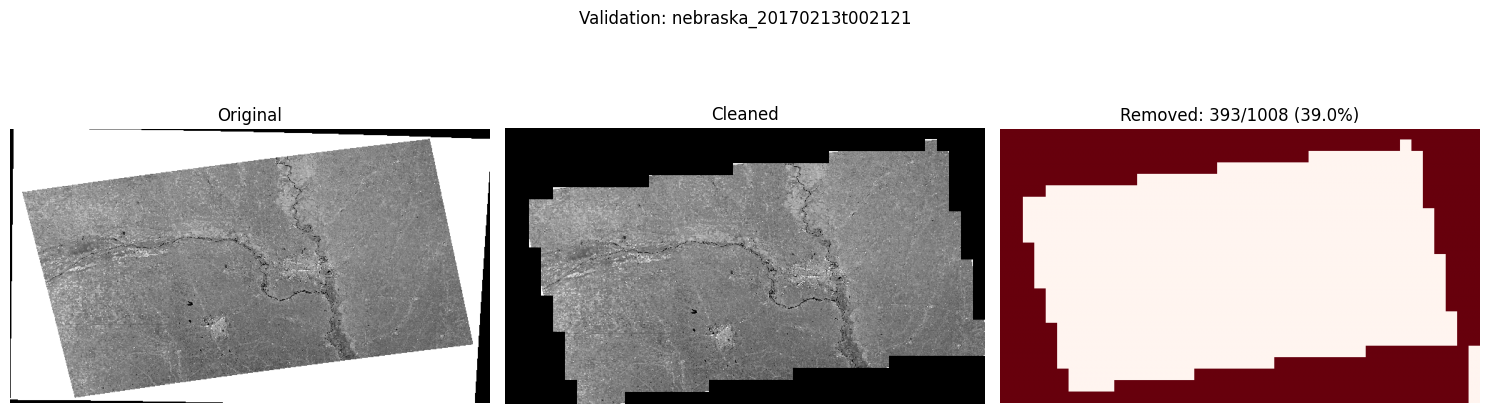

In [55]:
# Load same zone from original and cleaned datasets
VALIDATION_ZONE = "nebraska_20170213t002121"

original = load_low_res(f"../data/etci2021/train/{VALIDATION_ZONE}/tiles")
cleaned = load_low_res(f"../data/etci2021-clean/train/{VALIDATION_ZONE}/tiles")

vv_orig = original[2][:, :, 0]
vv_clean = cleaned[2][:, :, 0]

# Create comparison mask
removed_mask = np.zeros(vv_orig.shape, dtype=bool)
patch_size = 16
for i in range(vv_orig.shape[0] // patch_size):
    for j in range(vv_orig.shape[1] // patch_size):
        orig_patch = vv_orig[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        clean_patch = vv_clean[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        if np.all(clean_patch == 0) and not np.all(orig_patch == 0):
            removed_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = True

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(vv_orig, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(vv_clean, cmap='gray')
axes[1].set_title("Cleaned")
axes[1].axis('off')

total = (vv_orig.shape[0] // patch_size) * (vv_orig.shape[1] // patch_size)
removed = np.sum(removed_mask) // (patch_size * patch_size)
axes[2].imshow(removed_mask, cmap='Reds')
axes[2].set_title(f"Removed: {removed}/{total} ({removed/total*100:.1f}%)")
axes[2].axis('off')

plt.suptitle(f"Validation: {VALIDATION_ZONE}", fontsize=12)
plt.tight_layout()
plt.show()